# Ask-Tell Example with `ExpectedImprovementXsi` and `AskTellHistory`

This notebook demonstrates how to use the lower-level `ask-tell` interface in Trieste for Bayesian optimization. 

We will:
1. Use the well-known 2D **Branin** function as the objective to minimize.
2. Employ the custom `ExpectedImprovementXsi` acquisition function from the local `online_neuro` library.
3. Use a standard `GaussianProcessRegression` model.
4. Manually run the optimization loop using `ask_tell.ask()` and `ask_tell.tell()`.
5. Keep track of the optimization process using `AskTellHistory`.
6. Plot the results gathered in the history object.

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.ask_tell_optimization import AskTellOptimizer

# Trieste imports
from trieste.data import Dataset
from trieste.models.gpflow import GaussianProcessRegression, build_gpr
from trieste.objectives import ScaledBranin
from trieste.objectives.utils import mk_observer

# Local imports
sys.path.append("../")
from online_neuro.bayessian_optimizer import AskTellOptimizerHistory
from online_neuro.custom_acquisitions import ExpectedImprovementXsi

# Matplotlib settings for prettier plots
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["font.size"] = 12

2025-12-19 15:16:16.786724: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-19 15:16:16.788599: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-19 15:16:16.817937: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-19 15:16:16.818508: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-19 15:16:17.346828: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

### 1. Set up the Objective Function and Initial Data

In [2]:
search_space = ScaledBranin.search_space
observer = ScaledBranin.objective

# Get 5 initial data points using a Sobol sequence for good coverage
num_initial_points = 5
initial_query_points = search_space.sample(num_samples=num_initial_points)
initial_observations = observer(initial_query_points)


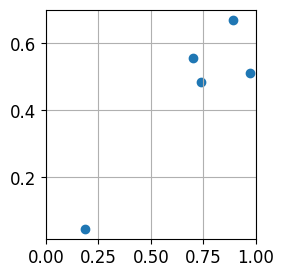

In [20]:
plt.figure(figsize=(3,3))
plt.scatter(initial_query_points[:,0], 
            initial_query_points[:,1])
plt.xlim(search_space.lower[0],search_space.upper[0])
plt.xlim(search_space.lower[0],search_space.upper[1])
plt.grid()

In [21]:
initial_data = Dataset(initial_query_points, initial_observations)

### 2. Define the Model and `AskTell` Optimizer

In [22]:
# Build a standard GPR model
gpflow_model = build_gpr(initial_data, search_space, likelihood_variance=1e-5)
model = GaussianProcessRegression(gpflow_model)

# Set up the custom acquisition function
# A small positive xsi encourages exploration
acq = ExpectedImprovementXsi(xsi=0.01)
rule = EfficientGlobalOptimization(acq)

# Instantiate the AskTell optimizer
ask_tell = AskTellOptimizer(datasets=initial_data,
                            search_space=search_space,
                            models=model,
                            acquisition_rule=rule)

### 3. Run the Ask-Tell Optimization Loop

In [23]:
num_steps = 20

print(f"Running ask-tell loop for {num_steps} steps...")
history = {
    "query_points":[],
    "observations":[]
}
for step in range(num_steps):
    # Get new point recommendation
    new_point = ask_tell.ask()
    
    # Observe the objective function at the new point
    new_observation = observer(new_point)
    
    new_data = Dataset(new_point, new_observation)
    # Update the model with the new observation
    ask_tell.tell(new_data)
    
    # Store the result in our history
    history['query_points'].append(new_point)
    history['observations'].append(new_observation)
    
    print(f"Step {step+1:2d}: queried point {new_point.numpy().squeeze()} | objective: {new_data.observations.numpy().squeeze():.3f}")

print("Optimization finished.")

Running ask-tell loop for 20 steps...
Step  1: queried point [0.97216191 0.47090232] | objective: -0.664
Step  2: queried point [1.         0.43223037] | objective: -0.784
Step  3: queried point [1.         0.33238731] | objective: -0.942
Step  4: queried point [1.         0.20789312] | objective: -1.017
Step  5: queried point [0.91888577 0.15283266] | objective: -1.009
Step  6: queried point [0.96453882 0.        ] | objective: -0.926
Step  7: queried point [0.96137499 0.18130165] | objective: -1.046
Step  8: queried point [0.75580659 0.        ] | objective: -0.655
Step  9: queried point [0. 1.] | objective: -0.718
Step 10: queried point [0.20660597 1.        ] | objective: -0.339
Step 11: queried point [0.         0.70679597] | objective: 0.025
Step 12: queried point [0.94974231 0.23077158] | objective: -1.020
Step 13: queried point [0.97219208 0.12981896] | objective: -1.037
Step 14: queried point [0.54283271 0.        ] | objective: -0.948
Step 15: queried point [0.52603253 0.1802

### 4. Plot the Results

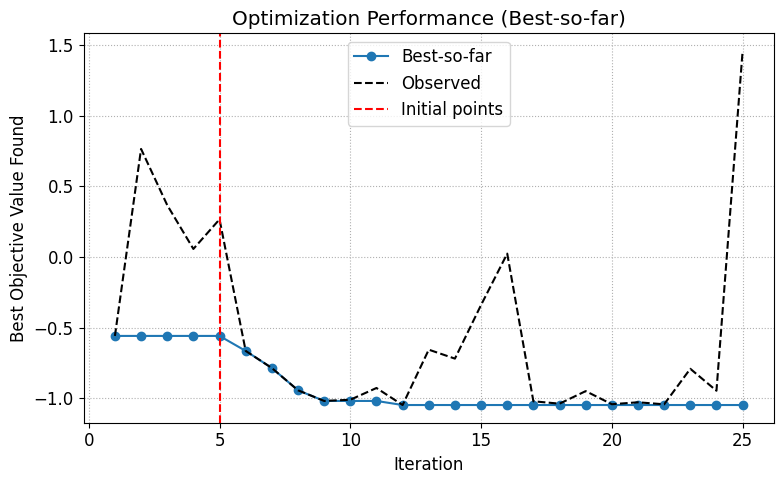

In [26]:
# Extract the collected data from the history object
final_dataset = ask_tell.datasets['OBJECTIVE']

query_points = final_dataset.query_points.numpy()
observations = final_dataset.observations.numpy()

# Calculate the best-so-far objective value at each step
best_at_each_step = np.minimum.accumulate(observations)

# Plot the performance over iterations
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(best_at_each_step) + 1), best_at_each_step, '-o', color='C0', label='Best-so-far')
plt.plot(np.arange(1, len(best_at_each_step) + 1), observations, '--', color='k', label='Observed')

plt.axvline(x=num_initial_points, color='red', linestyle='--', label='Initial points')
plt.title('Optimization Performance (Best-so-far)')
plt.xlabel('Iteration')
plt.ylabel('Best Objective Value Found')
plt.grid(True, which='both', linestyle=':')
plt.legend()
plt.show()

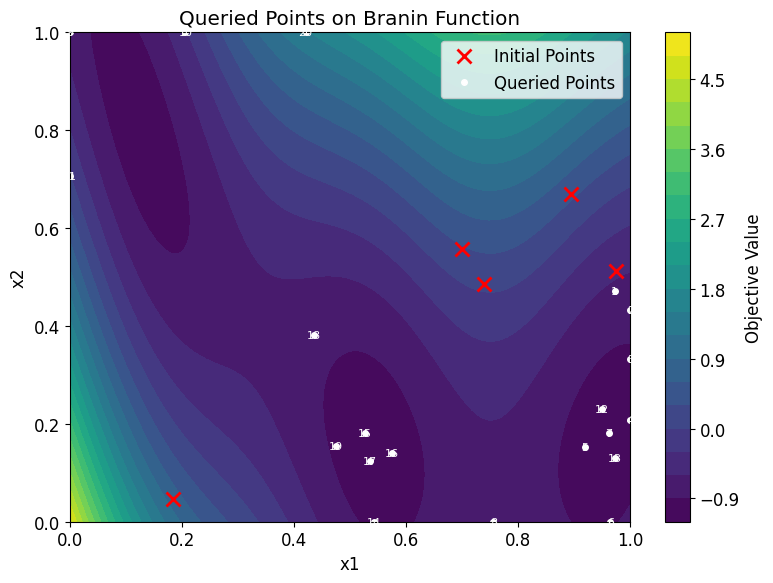

In [28]:
# Create a contour plot of the Branin function
mins = search_space.lower
maxs = search_space.upper
x_grid = np.linspace(mins[0], maxs[0], 100)
y_grid = np.linspace(mins[1], maxs[1], 100)
xx, yy = np.meshgrid(x_grid, y_grid)
grid_points = np.vstack([xx.ravel(), yy.ravel()]).T
zz = observer(grid_points).numpy().reshape(xx.shape)

plt.figure(figsize=(8, 6))
contour = plt.contourf(xx, yy, zz, levels=20, cmap='viridis')
plt.colorbar(contour, label='Objective Value')

# Overlay the queried points
initial_points = query_points[:num_initial_points]
sequential_points = query_points[num_initial_points:]

plt.plot(initial_points[:, 0], initial_points[:, 1], 'rx', markersize=10, mew=2, label='Initial Points')
plt.plot(sequential_points[:, 0], sequential_points[:, 1], 'w.', markersize=8, label='Queried Points')

# Annotate the sequential points with their iteration number
for i, p in enumerate(sequential_points):
    plt.text(p[0], p[1], str(i + 1), color='white', ha='center', va='center', fontsize=8)

plt.title('Queried Points on Branin Function')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()